# Genomic Grammar Data Visualization

## Imports

In [1]:
import os
import numpy as np
import Bio
from Bio import SeqIO
import seaborn as sns
import pandas as pd
import Bio.motifs
%matplotlib inline
from sklearn import model_selection
import seaborn as sns
from matplotlib import pyplot as plt
import sklearn
from IPython.display import SVG
sns.set_context('notebook')

## Functions

In [82]:
def quantile_normalize_df(df_input):
    df = df_input.copy()
    #compute rank
    dic = {}
    for col in df:
        dic.update({col : sorted(df[col])})
    sorted_df = pd.DataFrame(dic)
    rank = sorted_df.mean(axis = 1).tolist()
    #sort
    for col in df:
        t = np.searchsorted(np.sort(df[col]), df[col])
        df[col] = [rank[i] for i in t]
    return df

In [2]:
if not os.path.isdir('/home/jtao/analysis/genomic_grammar_analysis/'):
    os.mkdir('/home/jtao/analysis/genomic_grammar_analysis')
os.chdir('/home/jtao/analysis/genomic_grammar_analysis')

In [4]:
summary_frame = pd.read_csv('./group_atac_summary.tsv' , sep='\t', low_memory=False)
summary_frame = summary_frame.fillna('0')
for col in summary_frame.columns[5:]:
    floatValues = []
    for val in summary_frame[col].values.astype(str):
        if ',' in val:
            maxVal = np.mean([float(x) for x in val.split(',')])
            floatValues.append(maxVal)
        else:
            floatValues.append(float(val))
    summary_frame[col] = floatValues
# summary_frame.index = summary_frame['ID'].values
summary_frame.index = summary_frame['chr'] + ':' + (summary_frame['start'] - 1).astype(str) + '-' + summary_frame['end'].astype(str)

# remove peaks in unknown/random chromosomes
summary_frame = summary_frame[~summary_frame['chr'].str.contains('random')]
summary_frame = summary_frame[~summary_frame['chr'].str.contains('Un')]

## RNA

## ATAC

## H3K27Ac

In [247]:
id_coordID_dict = dict(zip(summary_frame['ID'], summary_frame.index.values))

In [248]:
# average tag counts from both replicates
h3k27ac_tag_frame = pd.read_csv('./merged_atac_annotated_h3k27ac_peaks.tsv', sep='\t')
h3k27ac_tag_frame.index = [id_coordID_dict[x] for x in h3k27ac_tag_frame.iloc[:,0]]
h3k27ac_tag_frame = h3k27ac_tag_frame[[x for x in h3k27ac_tag_frame.columns.values if 'Tag Count' in x]]
columns = [x.split(' ')[0].split('/')[2].lower() for x in h3k27ac_tag_frame.columns.values]
columns = [x.split('_')[4] + '_' + x.split('_')[6] for x in columns]
h3k27ac_tag_frame.columns = columns

factor_treatments = sorted(set(['_'.join(x.split('_')[:5]) for x in columns]))

h3k27ac_meanTag_dict = {}
for ft in factor_treatments:
    cleaned_ft = ft.split('_')[0]
    h3k27ac_meanTag_dict[cleaned_ft] = h3k27ac_tag_frame[[x for x in h3k27ac_tag_frame.columns if ft in x]].mean(axis=1).values
h3k27ac_meanTag_frame = pd.DataFrame(h3k27ac_meanTag_dict)
h3k27ac_meanTag_frame.index = h3k27ac_tag_frame.index.values

In [249]:
condition_string = ' '.join([x.split('_')[0] for x in h3k27ac_tag_frame.columns])

In [250]:
print('getDiffExpression.pl ./merged_atac_annotated_h3k27ac_peaks.tsv -AvsA -peaks ' + condition_string + '> ./diff_h3k27Ac_peaks.tsv')

getDiffExpression.pl ./merged_atac_annotated_h3k27ac_peaks.tsv -AvsA -peaks il4-24h il4-24h kla-1h kla-1h veh veh> ./diff_h3k27Ac_peaks.tsv


In [251]:
!getDiffExpression.pl ./merged_atac_annotated_h3k27ac_peaks.tsv -AvsA -peaks $condition_string > ./diff_h3k27Ac_peaks.tsv''


	Differential Expression Program: edgeR
	Treating input as file generated by annotatePeaks.pl (-peaks)
	Using edgeR to calculate differential expression/enrichment...
	Output Stats il4-24h vs. kla-1h:
		Total Genes: 54771
		Total Up-regulated in kla-1h vs. il4-24h: 3702 (6.759%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in kla-1h vs. il4-24h: 5190 (9.476%) [log2fold<-1, FDR<0.05]
	Output Stats il4-24h vs. veh:
		Total Genes: 54771
		Total Up-regulated in veh vs. il4-24h: 207 (0.378%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in veh vs. il4-24h: 673 (1.229%) [log2fold<-1, FDR<0.05]
	Output Stats kla-1h vs. veh:
		Total Genes: 54771
		Total Up-regulated in veh vs. kla-1h: 7633 (13.936%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in veh vs. kla-1h: 5749 (10.496%) [log2fold<-1, FDR<0.05]



In [252]:
target_ids = summary_frame[summary_frame[['c57bl6_veh-24h', 'c57bl6_kla-1h', 'c57bl6_il4-24h']].max(axis=1) > 0].index.values

In [253]:
np.log2(h3k27ac_tag_frame.loc[target_ids, :]+1).mean(axis=0)

il4-24h_l20171004       3.989285
il4-24h_l20171129       3.824389
kla-1h_16-04-15-rep1    3.769416
kla-1h_16-04-15-rep2    3.709525
veh_l20171004           4.345759
veh_l20171121           4.107093
dtype: float64

In [254]:
np.log2(h3k27ac_tag_frame.loc[target_ids, :]+1).var(axis=0)

il4-24h_l20171004       4.032712
il4-24h_l20171129       3.646478
kla-1h_16-04-15-rep1    2.579762
kla-1h_16-04-15-rep2    2.489747
veh_l20171004           5.313697
veh_l20171121           5.119494
dtype: float64

In [255]:
np.log2(h3k27ac_meanTag_frame.loc[target_ids, :]+1).mean(axis=0)

il4-24h    3.824389
kla-1h     3.709525
veh        4.107093
dtype: float64

In [256]:
np.log2(h3k27ac_meanTag_frame.loc[target_ids, :]+1).var(axis=0)

il4-24h    3.646478
kla-1h     2.489747
veh        5.119494
dtype: float64

In [285]:
diff_tagFrame = pd.read_csv('./diff_h3k27Ac_peaks.tsv', sep='\t')

In [286]:
diff_tagFrame.index =  [id_coordID_dict[x] for x in diff_tagFrame.iloc[:,0]]

In [287]:
p_threshold = 0.05
fold_threshold = 1
differential_indices = diff_tagFrame[(diff_tagFrame[[x for x in diff_tagFrame.columns if 'adj.' in x]].min(axis=1) < p_threshold) &
                                    (diff_tagFrame[[x for x in diff_tagFrame.columns if 'Fold Change' in x]].abs().max(axis=1) >=fold_threshold)].index.values

In [288]:
len(differential_indices)

16325

In [289]:
normed_h3k27ac_tag_frame = quantile_normalize_df(h3k27ac_tag_frame)
normed_h3k27ac_meanTag_frame = quantile_normalize_df(h3k27ac_meanTag_frame)

(16325, 6)


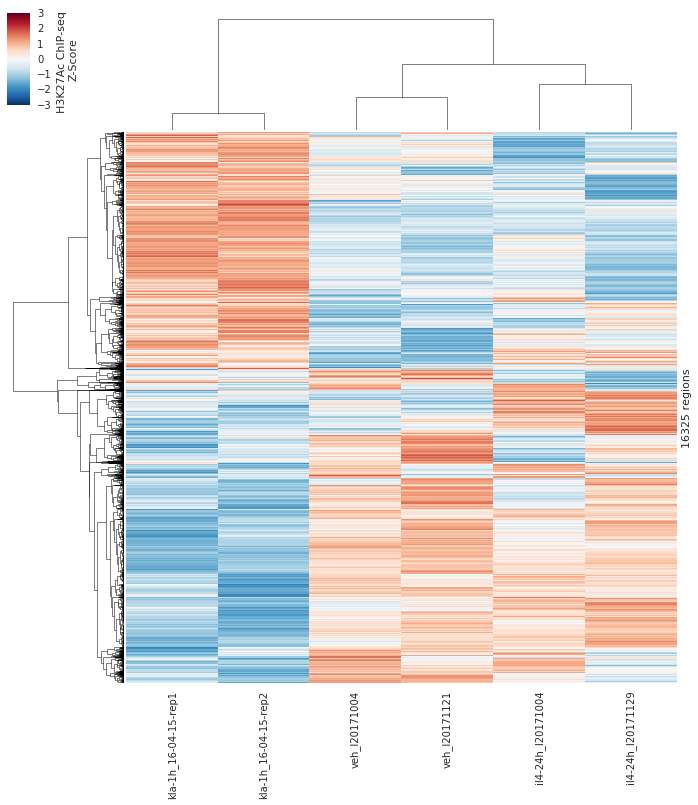

In [292]:
data = normed_h3k27ac_tag_frame.loc[differential_indices, :]
data = data[data.max(axis=1) >=0]
data= data[data.var(axis=1)>0]
cg = sns.clustermap(np.log2(data+1), 
                   z_score=0,
                    metric='correlation',
                   yticklabels = False,
                   vmin = -3,
                   vmax = 3,
                   figsize=(12,12), 
                   cbar_kws={'label': 'H3K27Ac ChIP-seq \nZ-Score'})
cg.ax_heatmap.set_ylabel(str(data.shape[0]) + ' regions')
# .title()
plt.savefig('./figures/h3k27ac_clustermap.png', bbox_inches='tight')
print(data.shape)

(13251, 3)


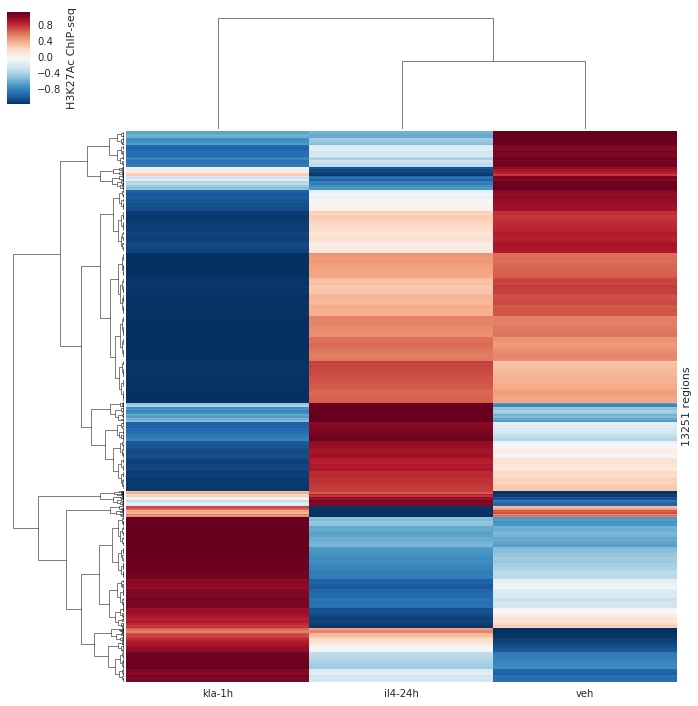

In [263]:
data = normed_h3k27ac_meanTag_frame.loc[differential_indices, :]
data= data[data.var(axis=1)>0]
data = data[data.max(axis=1) >=16]
cg = sns.clustermap(np.log2(data+1), 
                   z_score=0,
                   yticklabels = False,
#                    vmin = -3,
#                    vmax = 10,
                   figsize=(12,12), 
                   cbar_kws={'label': 'H3K27Ac ChIP-seq'})
cg.ax_heatmap.set_ylabel(str(data.shape[0]) + ' regions')

print(data.shape)

In [278]:
h3k27ac_meanTag_frame.to_csv('./h3k27ac_reads.tsv', sep='\t')

In [264]:
normed_h3k27ac_meanTag_frame.to_csv('./normed_h3k27ac_reads.tsv', sep='\t')

In [273]:
normed_h3k27ac_meanTag_frame.loc[differential_indices, :].to_csv('./normed_diff_h3k27ac_reads.tsv', sep='\t')

In [367]:
predictions = pd.read_csv('./predictions.tsv', sep='\t', index_col=0)

In [368]:
prediction_data = predictions.loc[differential_indices,:]
actual_data = normed_h3k27ac_meanTag_frame.loc[differential_indices, :]
data = pd.concat([prediction_data, actual_data], axis=1)

In [369]:
quantiled_data = quantile_normalize_df(data)

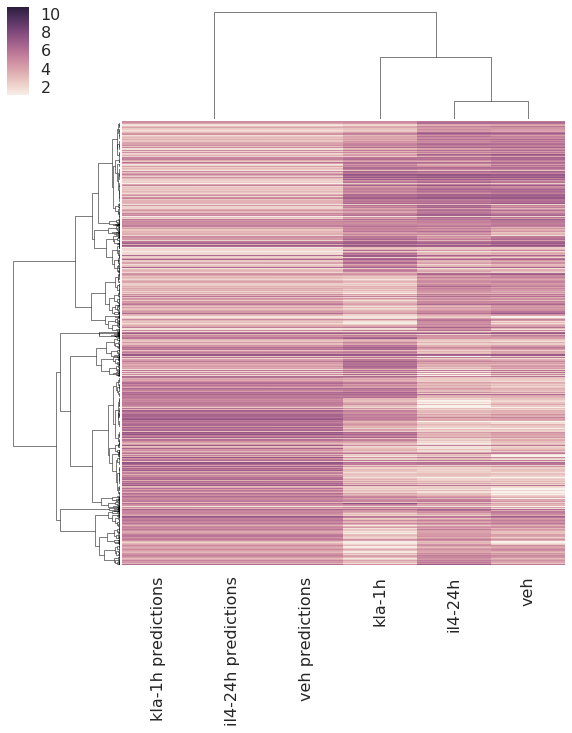

In [370]:
cg = sns.clustermap(np.log2(quantiled_data+1),
#                     z_score=0,
                    metric = 'correlation',
                   yticklabels = False,
#                     vmax=2,
#                     vmin=-2
                   )

## ATAC TBA

In [ ]:
%%bash
if [ ! -d ./bed_files/ ]; then mkdir ./bed_files; fi
if [ ! -d ./peak_sequences/ ]; then mkdir ./peak_sequences; fi
if [ ! -d ./background_files/ ]; then mkdir ./background_files; fi
if [ ! -d ./tba_output/ ]; then mkdir ./tba_output; fi
for peak_file in ./atac_idr_peaks/*;
do bed_file=${peak_file/tsv/bed};
bed_file=${bed_file/atac_idr_peaks/bed_files}
# echo "pos2bed.pl $peak_file > $bed_file";
# pos2bed.pl $peak_file > $bed_file
seq_file=${bed_file/peaks.bed/peaks.fasta};
seq_file=${seq_file/bed_files/peak_sequences};
# echo "/home/jtao/code/tba/model_training/extract_sequences.py $bed_file mm10 $seq_file";
# echo "/home/jtao/code/tba/model_training/generate_background_coordinates.py $bed_file mm10 ./background_files/"
bg_seq_file=${seq_file/peak_sequences/background_files};
bg_seq_file=${bg_seq_file/peaks.fasta/background.fasta};
# echo "mv ./background_files/background.fasta $bg_seq_file"
# echo "/home/jtao/code/tba/model_training/create_features.py $seq_file $bg_seq_file ./tba_output /home/jtao/code/tba/default_motifs/*"
combined_features=${seq_file/peak_sequences/tba_output}
combined_features=${combined_features/.fasta/_combined_features.tsv}
labels=${combined_features/combined_features.tsv/labels.txt}
echo "/home/jtao/code/tba/model_training/train_classifier.py $combined_features $labels ./tba_output/"
coeff_path=${combined_features/combined_features.tsv/coefficients.tsv}
performance_path=${combined_features/combined_features.tsv/performance.tsv}
echo "mv ./tba_output/coefficients.tsv $coeff_path"
echo "mv ./tba_output/performance.tsv $performance_path"
echo "/home/jtao/code/tba/model_training/calc_feature_significance.py $combined_features $labels ./tba_output/"
significance_path=${combined_features/combined_features.tsv/significance.tsv}
echo $mv ./tba_output/significance.tsv $significance_path

done

In [300]:
sample_weights_dict = {}
for f in os.listdir('./tba_output/'):
    if 'coefficients' in f:
        frame = pd.read_csv('./tba_output/' + f, sep='\t', index_col=0)
        mean_weights = frame.mean(axis=1)
        sample = '_'.join(f.split('_')[0:2])
        sample_weights_dict[sample] = mean_weights

mean_weights_frame = pd.DataFrame(sample_weights_dict, index = sample_weights_dict[list(sample_weights_dict.keys())[0]].index.values)
mean_weights_frame = mean_weights_frame[mean_weights_frame.isnull().max(axis=1) ==False]

In [306]:
mean_weights_frame.drop('c57bl6_veh-24h', axis=1, inplace=True)
mean_weights_frame.drop('c57bl6_il5-24h', axis=1, inplace=True)

In [307]:
sample_pval_dict = {}
for f in os.listdir('./tba_output/'):
    if 'significance' in f:
        frame = pd.read_csv('./tba_output/' + f, sep='\t', index_col=0)
        mean_pval = frame.mean(axis=1)
        sample = '_'.join(f.split('_')[0:2])
        sample_pval_dict[sample] = mean_pval

mean_pval_frame = pd.DataFrame(sample_pval_dict, index = sample_pval_dict[list(sample_pval_dict.keys())[0]].index.values)
mean_pval_frame = mean_pval_frame[mean_pval_frame.isnull().max(axis=1) ==False]

In [309]:
mean_pval_frame.drop('c57bl6_veh-24h', axis=1, inplace=True)
mean_pval_frame.drop('c57bl6_il5-24h', axis=1, inplace=True)

In [322]:
mean_pval_frame.columns

Index(['c57bl6_ifng-24h', 'c57bl6_il13-24h', 'c57bl6_il1b-24h',
       'c57bl6_il23-24h', 'c57bl6_il4-24h', 'c57bl6_il6-24h', 'c57bl6_kla-1h',
       'c57bl6_tgfb-24h', 'c57bl6_tnfa-24h', 'c57bl6_veh'],
      dtype='object')

In [317]:
sns.set_context('poster')

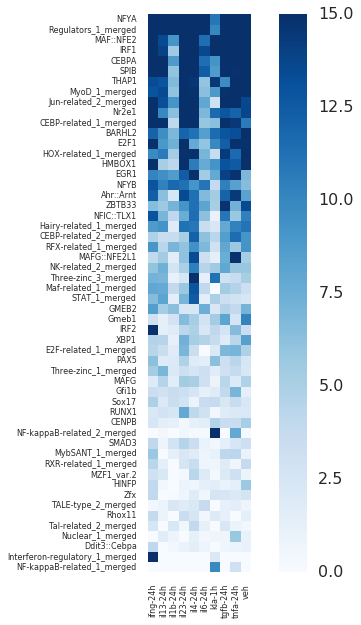

In [360]:
pseudocount = 1e-15
treatments = mean_pval_frame.columns
treatment_orientedPvals_dict = {}
for treatment in treatments:
    pvals = mean_pval_frame[treatment]
    weights = mean_weights_frame[treatment]
    
    oriented_pvals = [np.log10(x[0] +pseudocount) if x[1] < 0 else -np.log10(x[0]+pseudocount) for x in zip(pvals, weights)]
    treatment_orientedPvals_dict[treatment.replace('c57bl6_','')] = oriented_pvals
frame = pd.DataFrame(treatment_orientedPvals_dict, index = mean_pval_frame.index.values)
frame['mean'] = frame.mean(axis=1)
frame.sort_values('mean', ascending = False, inplace=True)
frame.drop('mean', axis=1, inplace=True)
frame = frame[frame.max(axis=1) > 1]
plt.figure(figsize=(10,10))
filtered_frame = frame[((frame.max(axis=1) - frame.min(axis=1)).abs() >=4)]
hm = sns.heatmap(filtered_frame,
     vmin=0,
     cmap='Blues',
     square=True)
pos = hm.get_position()
# hm.set_position([pos.x0, pos.y0, pos.width/5, pos.height*2])
hm.set_yticklabels(size=8, labels = filtered_frame.index.values[::-1]);
hm.set_xticklabels(size=8, labels = filtered_frame.columns.values, rotation=90);
plt.savefig('./figures/tba_heatmap_heatmap.pdf',bbox_inches='tight')

In [366]:
pval_threshold = 10**-5
positive_motif_set = None
for treatment in treatments:
    pvals = mean_pval_frame[treatment]
    weights = mean_weights_frame[treatment]


    significant_positive_motifs = weights[weights>0].index.intersection(pvals[pvals < pval_threshold].index)
    if positive_motif_set == None:
        positive_motif_set = set(significant_positive_motifs)
    else:
        positive_motif_set = positive_motif_set.intersection(set(significant_positive_motifs)) 
data = mean_pval_frame.loc[sorted(positive_motif_set), [x for x in members]]

data = data+1e-50

positive_table = data[[]]
positive_table['Motif'] = data.index.values
positive_table['Mean p-val'] = data.mean(axis=1)
positive_table.sort_values(by='Mean p-val', inplace = True)
positive_table.to_csv('./figures/postive_motif_table.tsv', sep='\t', index = False)
positive_table

/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

,Motif,Mean p-val
CTCF,CTCF,1.000000e-50
Ets-related_1_merged,Ets-related_1_merged,1.000000e-50
Jun-related_1_merged,Jun-related_1_merged,1.000000e-50
Klf12,Klf12,1.000000e-50
Gabpa,Gabpa,1.598435e-34
Runt-related_1_merged,Runt-related_1_merged,4.760477e-28
Ets-related_2_merged,Ets-related_2_merged,1.792717e-26
STAT1::STAT2,STAT1::STAT2,1.284230e-23
ZNF143,ZNF143,1.974585e-21
Pax2,Pax2,1.390108e-20
